In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [5]:
class massClass:
    def __init__(self):
        # Stages
        self.stages = ["S200","L110","C25"]
        # propellant Mass in tonne
        self.propMass = np.array([410.0, 116.0, 28.0])
        # empty mass in tonne
        self.emptyMass = np.array([62.0, 9.0, 5.0])
        self.othermass = 12
        self.MTOW = self.propMass.sum() + self.emptyMass.sum() + self.othermass
        # flightEvents
        self.ignitionT = np.array([0.0, 108.10, 307.96])
        self.separationT = np.array([127.0, 305.56 ,954.42])
        # burnTime
        self.burnTime = self.separationT - self.ignitionT
        self.burnRate = self.propMass/self.burnTime
    def editPropMass(self,mass,i):
        self.propMass[i] = self.propMass[i]+mass
        self.burnRate = self.propMass/self.burnTime
        self.MTOW = self.MTOW + mass
    def editOtherMass(self,mass):
        self.othermass = self.othermass + mass
        self.MTOW = self.MTOW + mass
    def burntMass(self,i,t):
        return  self.burnRate[i]*(min(t,self.separationT[i])-self.ignitionT[i])
    def mass(self,t):
        if(t<self.ignitionT[1]):
            return self.MTOW - self.burntMass(0,t)
        elif(t<self.separationT[0]):
            return self.MTOW - self.burntMass(0,t) - self.burntMass(1,t)
        elif(t<self.separationT[1]):
            return self.MTOW - self.emptyMass[0] - self.propMass[0] - self.burntMass(1,t)
        elif(t<self.ignitionT[2]):
            return self.MTOW - sum(self.emptyMass[0:2]) - sum(self.propMass[0:2])
        elif(t<self.separationT[2]):
            return self.MTOW - sum(self.emptyMass[0:2]) - sum(self.propMass[0:2]) - self.burntMass(2,t)
        else:
            return self.MTOW - self.emptyMass.sum() - self.propMass.sum()

In [6]:
allData = pd.read_excel("alldata.xlsx")

In [7]:
allData["disp"] = np.zeros(allData.shape[0])
for i in range(1,966):
    allData.loc[i,"disp"] = max(0,allData["altKm"][i]-allData["altKm"][i-1])

In [8]:
allData.head()

,Unnamed: 0,time,altKm,velkmps,dynPinKPa,accing,disp
0,0,0,0.0,0.000,0.485466,-0.007979,0.0
1,1,1,0.2,0.007,0.441821,0.098039,0.2
2,2,2,0.2,0.012,0.392086,0.203021,0.0
3,3,3,0.3,0.017,0.356441,0.305759,0.1
4,4,4,0.3,0.024,0.355086,0.405109,0.0


In [9]:
Q_infty = np.array(allData["dynPinKPa"]) # in KPa
disp = np.array(allData["disp"]) # in Km
acc = np.array(allData["accing"]) # in g

In [10]:
class energyclass():
    def __init__(self):
        self.R = 5.0/2
        self.S = np.pi*self.R**2
        self.Cd = 0.3
    def dragE(self,Q_infty, disp):
        self.disp = np.array(disp)
        self.Edrag = sum(self.S*self.Cd*Q_infty*self.disp) # in Mega joule cz of KPa and Km
        return self.Edrag
    def interiaE(self,mass,acc, disp):
        self.disp = np.array(disp)
        mass = np.array(mass)
        acc = (np.array(acc) + 1)*9.8
        self.Einertia = sum(mass*acc*self.disp) # in mega joule cz of tonne and Km
        return self.Einertia
    def totalE(self):
        return self.Edrag+self.Einertia

In [11]:
# energy consumed till 108 sec
e = energyclass()
m = massClass()
E_till_108 = e.dragE(Q_infty[0:108], disp[0:108]) + e.interiaE(np.array([m.mass(i) for i in range(0,108)]),acc[0:108],disp[0:108])
S200_propM_till_108 = m.burntMass(0,108)
# Energy per unit mass
EpM = E_till_108/S200_propM_till_108

In [12]:
E_till_108

469687.8222855577

In [13]:
def energyDiff(excess_propellant,excess_payload,t):
    m_1 = massClass()
    e_1 = energyclass()
    energySpent_old = e_1.dragE(Q_infty[0:t], disp[0:t]) + e_1.interiaE(np.array([m_1.mass(i) for i in range(0,t)]),acc[0:t],disp[0:t])
    energyAvailable_old = EpM*m_1.burntMass(0,t) 
    m_1.editOtherMass(excess_payload)
    m_1.editPropMass(excess_propellant,0)
    energySpent = e_1.dragE(Q_infty[0:t], disp[0:t]) + e_1.interiaE(np.array([m_1.mass(i) for i in range(0,t)]),acc[0:t],disp[0:t])
    energyAvailable = EpM*m_1.burntMass(0,t)
    return ((energyAvailable-energyAvailable_old)-(energySpent-energySpent_old))

In [14]:
# energyDiff(0,1,127)

In [15]:
# t=127

In [16]:
# energySpent_test = e.dragE(Q_infty[0:t], disp[0:t]) + e.interiaE(np.array([m.mass(i) for i in range(0,t)]),acc[0:t],disp[0:t])
# energySpent_test_new = e.dragE(Q_infty[0:t], disp[0:t]) + e.interiaE(np.array([m.mass(i) for i in range(0,t)])+10,acc[0:t],disp[0:t])


In [17]:
# energySpent_test_new - energySpent_test

In [18]:
def firstPositive(arr):
    for i in range(0,len(arr)):
        if(arr[i]>=0):
            return i

In [19]:
extraPayloadMass = np.arange(5)
timeArr = np.array([0,127,194,305,954])
extraPropellantMass = np.zeros((5,len(timeArr)))
for p in range(0,len(timeArr)):
    for i in range(0,len(extraPayloadMass)):
        extraPropellantMass[p][i] = firstPositive([energyDiff(j,extraPayloadMass[i],timeArr[p]) for j in range(0,100)])

In [20]:
extraPropellantMass

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  4.,  6.,  8.],
       [ 0.,  3.,  6.,  9., 12.],
       [ 0.,  5., 10., 15., 20.],
       [ 0.,  7., 13., 19., 25.]])

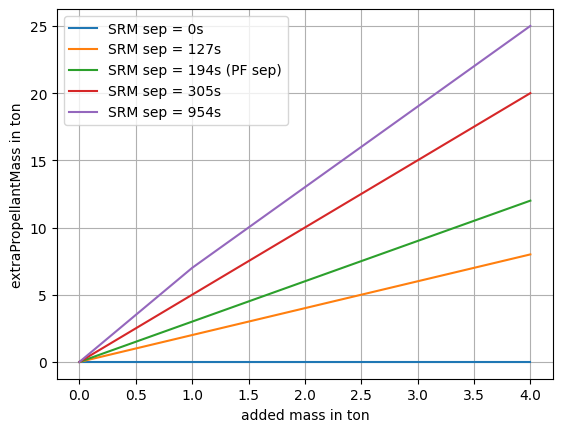

In [21]:
plt.plot(extraPayloadMass,extraPropellantMass[0])
plt.plot(extraPayloadMass,extraPropellantMass[1])
plt.plot(extraPayloadMass,extraPropellantMass[2])
plt.plot(extraPayloadMass,extraPropellantMass[3])
plt.plot(extraPayloadMass,extraPropellantMass[4])
plt.legend(labels=['SRM sep = 0s','SRM sep = 127s','SRM sep = 194s (PF sep)','SRM sep = 305s','SRM sep = 954s'])
plt.xlabel("added mass in ton")
plt.ylabel("extraPropellantMass in ton")
plt.grid()

In [22]:
e.dragE(Q_infty[0:2], disp[0:2])

0.5205083641912169

In [23]:
Q_infty[0:3]

array([0.48546568, 0.44182122, 0.39208593])

In [24]:
np.zeros((4,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [25]:
# def EnergyDiff(excess_payload_mass,excess_propellant_mass,till):
#     m_1 = massClass()
#     e_1 = energyclass()
#     # E_spent =  e.dragE(Q_infty[0:till], disp[0:till]) + e.interiaE(np.array([m_1.mass(i) for i in range(0,till)]),acc[0:till],disp[0:till])
#     # E_available = EpM*m_1.propMass[0]
#     m_1.editPropMass(excess_propellant_mass,0)
#     m_1.editOtherMass(excess_payload_mass)
#     E_spent_new =  e.dragE(Q_infty[0:till], disp[0:till]) + e.interiaE(np.array([m_1.mass(i) for i in range(0,till)]),acc[0:till],disp[0:till])
#     E_available_new = EpM*m_1.propMass[0]
#     return (E_available_new-E_spent_new)
#     # return ((E_available_new-E_available)-(E_spent_new-E_spent))    

In [26]:
# energyDiffarr = np.zeros(100)
# for i in range(0,100):
#     energyDiffarr[i] = EnergyDiff(1,i,108)

In [27]:
# energyDiffarr

In [28]:
# # calculating s200 energy per unit mass
# EpM = np.zeros(108)
# e_EpM = energyclass()
# m_EpM = massClass()
# for i in range(1,108):
#     massBurnt = m_EpM.burntMass(0,i)
#     massAti = [m_EpM.mass(j) for j in range(0,i+1)] 
#     energySpent = e_EpM.dragE(allData["dynPinKPa"][0:i+1],allData["disp"][0:i+1])+e_EpM.interiaE(massAti,allData["accing"][0:i+1],allData["disp"][0:i+1])
#     EpM[i] = energySpent/massBurnt

In [29]:
# plt.plot(np.arange(0,108),EpM[0:108])
# plt.xlabel("time in s")
# plt.ylabel("Energy (MJ) spent per unit mass (ton)")

In [30]:
# X = np.array((np.arange(5,108)).reshape(-1, 1))
# y = np.array(EpM[5:108].reshape(-1, 1))
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [31]:
# regr = LinearRegression()
# regr.fit(X, y)

In [32]:
# ypred = regr.predict(X)

In [33]:
# plt.plot(X,y)
# plt.plot(X,ypred)
# plt.show()

In [34]:
# optimization


In [35]:
# # Optimization
# m_optmization = massClass()
# e_optimization = energyclass()
# energyDiff = np.zeros(100)
# for i in range (0,100):
#     energyAvailable = sum(ypred)*(m_optmization.burnRate[0]+i)/len(ypred)
#     mfors200_new = [m_optmization.mass(j) + 1.5 + i for j in range(5,108)]
#     energyReq = e_optimization.dragE(allData["dynPinKPa"][5:108],allData["disp"][5:108])+e_optimization.interiaE(mfors200_new,allData["accing"][5:108],allData["disp"][5:108])
#     energyDiff[i]=energyAvailable-energyReq

In [36]:
# energyDiff